### Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import itertools as itertls
import warnings

from tqdm import notebook
from tqdm import tqdm 
from typing import Union

# from scipy.stats import pearsonr, spearmanr, chi2, chi2_contingency
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.seasonal import STL

from sklearn.metrics import mean_squared_error, mean_absolute_error, \
                            mean_absolute_percentage_error

In [2]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  "font.size": 16,
  "grid.alpha": 0.25})

### Function declarations

In [3]:
def plot_time_series(x, y, xlabel="Time", ylabel="Value", figsize=(12, 4), 
                     use_date_locator=True, title=None, use_scatter=True):
    fig, ax = plt.subplots(figsize=figsize)

    ax.plot(x, y, linestyle="-", marker=".")

    if use_date_locator:
        formatter = mdates.DateFormatter("%d/%m/%Y")
        # locator = mdates.WeekLocator()
        # locator = mdates.YearLocator(base=2)
        locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 3))
        ax.xaxis.set_major_formatter(formatter)
        ax.xaxis.set_major_locator(locator)

    ax.grid("on")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if title is not None:
        ax.set_title(title)

    if use_date_locator:
        for j, label in enumerate(ax.get_xticklabels()):
            label.set_rotation(40)
            label.set_horizontalalignment('right')

    plt.show()


### Pre-processing

In [4]:
file_path = "./data/CDB THN 2021-2024.csv"
df_cdb = pd.read_csv(file_path)
df_cdb["Tgl. Mohon"] = pd.to_datetime(df_cdb["Tgl. Mohon"], format="%d/%m/%Y")
df_cdb["Tgl. Lahir"] = pd.to_datetime(df_cdb["Tgl. Lahir"], format="%d/%m/%Y")
df_cdb

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA
...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0


In [5]:
df_cdb_with_initial = df_cdb.copy()
df_cdb_with_initial["initial Varian Plus"] = df_cdb_with_initial["Varian Plus"].apply(lambda x: x[0])
df_cdb_with_initial

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0,L
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0,L
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA,L
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0,L
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA,L
...,...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0,M
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0,M
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3,L
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0,M


In [6]:
df_cdb_with_tipe = df_cdb_with_initial.copy()

def tipe_customer(row):
    if row[["Gender", "Tgl. Lahir", "Pekerjaan", "Pengeluaran", "Pendidikan"]].isnull().any():
        return "INSTANSI LUAR"
    else:
        return "INDIVIDU"

df_cdb_with_tipe["Tipe Pembeli"] = df_cdb_with_tipe.apply(tipe_customer, axis=1)
df_cdb_with_tipe["Umur"] = (pd.to_datetime("today") - df_cdb_with_tipe["Tgl. Lahir"]).dt.days // 365

df_cdb_with_tipe

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus,Tipe Pembeli,Umur
0,2021-01-02,MULKAN,JL AL MAKMUR I,DAMAI,BALIKPAPAN KOTA,LAKI-LAKI,1996-08-18,Wiraswasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTP/SMP,LD0,L,INDIVIDU,28
1,2021-01-02,HANIE ZULFA NABIELA,JL MT HARYONO PERUM GRAND CITY,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,2003-04-14,Pegawai Swasta-Jasa,"< Rp. 900.000,-",AKADEMI/DIPLOMA,LP0,L,INDIVIDU,22
2,2021-01-02,HASANA PUTRI,JL LETJEND S PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1997-02-13,Pegawai Swasta-Pertanian,"Rp. 900.001,- s/d Rp. 1.250.000,-",SARJANA,LPA,L,INDIVIDU,28
3,2021-01-02,SUSARI HATI,JL MARSMA R ISWAHYUDI,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1982-11-16,Pegawai Swasta-Industri,"Rp. 4.000.001,- s/d Rp. 6.000.000,-",SLTA/SMU,LP0,L,INDIVIDU,42
4,2021-01-02,ROY KILAPONG,JL MT HARYONO,DAMAI BAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1976-01-17,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,LPA,L,INDIVIDU,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0,M,INDIVIDU,20
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0,M,INDIVIDU,47
6854,2024-08-31,JAMES HAROL SELA,JL. LETJEND. S. PARMAN,GUNUNGSARI ULU,BALIKPAPAN TENGAH,LAKI-LAKI,1961-01-19,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SARJANA,LP3,L,INDIVIDU,64
6855,2024-08-31,GOMGOM RAULI SIHOMBING,PERUM BDS II,SUNGAINANGKA,BALIKPAPAN SELATAN,PEREMPUAN,1980-04-30,IBU RUMAH TANGGA,"Rp. 1.250.001,- s/d Rp. 1.750.000,-",SLTA/SMU,ML0,M,INDIVIDU,45


### Plot kumulatif

Take initial varian plus "M"

In [7]:
df_M = df_cdb_with_tipe[df_cdb_with_tipe["initial Varian Plus"] == "M"].copy()
df_M

,Tgl. Mohon,Nama,Alamat,Kelurahan,Kecamatan,Gender,Tgl. Lahir,Pekerjaan,Pengeluaran,Pendidikan,Varian Plus,initial Varian Plus,Tipe Pembeli,Umur
2216,2022-07-26,ACHMAD YANI,JL JEND SUDIRMAN,DAMAI,BALIKPAPAN SELATAN,LAKI-LAKI,1980-06-22,Wiraswasta-Perdagangan,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,MA0,M,INDIVIDU,44
2262,2022-08-08,NURUL HASANAH,JL. SEPAKU LAUT GANG RUKUN,MARGA SARI,BALIKPAPAN BARAT,PEREMPUAN,1989-02-02,IBU RUMAH TANGGA,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,MB0,M,INDIVIDU,36
2267,2022-08-10,HERU BADRUDIN,PERUM GRIYA PERMATA ASRI JL.MC KENZIE,GUNUNGBAHAGIA,BALIKPAPAN SELATAN,LAKI-LAKI,1988-03-05,Pegawai Swasta-Perdagangan,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,MB0,M,INDIVIDU,37
2472,2022-09-19,RISWAN FEBRIYANTO BATARA,JL. DAKSA TIMUR XIII,SEPINGGAN,BALIKPAPAN SELATAN,LAKI-LAKI,1994-02-25,Pegawai Swasta-Pertanian,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SLTA/SMU,MB0,M,INDIVIDU,31
2513,2022-09-23,PT HARAPAN UTAMA MAKMUR,JL MT HARYONO,DAMAI,BALIKPAPAN KOTA,NaN,1979-07-18,NaN,NaN,NaN,MB0,M,INSTANSI LUAR,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6848,2024-08-31,DODI PRATAMA SUHARSO,BATU AMPAR PERMAL,GRAHA INDAH,BALIKPAPAN UTARA,LAKI-LAKI,1989-11-03,Pegawai Swasta-Jasa,"Rp. 2.500.001,- s/d Rp. 4.000.000,-",SARJANA,ML0,M,INDIVIDU,35
6851,2024-08-31,SUSAN HADINATA,JL. S. PARMAN,SUMBER REJO,BALIKPAPAN TENGAH,PEREMPUAN,1983-09-20,IBU RUMAH TANGGA,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MD1,M,INDIVIDU,41
6852,2024-08-31,RUDI AMSA,JL PADAT KARYA,MANGGAR,BALIKPAPAN TIMUR,LAKI-LAKI,2004-11-06,Pegawai Swasta-Jasa,"Rp. 900.001,- s/d Rp. 1.250.000,-",SLTA/SMU,MM0,M,INDIVIDU,20
6853,2024-08-31,MARIATI,JL. TAMAN BUKIT SARI,GRAHA INDAH,BALIKPAPAN UTARA,PEREMPUAN,1978-03-21,Pegawai Swasta-Jasa,"Rp. 1.750.001,- s/d Rp. 2.500.000,-",SLTA/SMU,MM0,M,INDIVIDU,47


Plot data initial varian plus "M"

In [8]:
df_M_count = df_M[["Tgl. Mohon"]].copy()
df_M_count["count"] = 1.
df_M_count = df_M_count.groupby("Tgl. Mohon").agg("count").reset_index()
df_M_count["cumulative_sum"] = df_M_count["count"].cumsum()
df_M_count["rolling_7days"] = df_M_count["count"].rolling(window=7, min_periods=1).sum()
df_M_count

,Tgl. Mohon,count,cumulative_sum,rolling_7days
0,2022-07-26,1,1,1.0
1,2022-08-08,1,2,2.0
2,2022-08-10,1,3,3.0
3,2022-09-19,1,4,4.0
4,2022-09-23,2,6,6.0
...,...,...,...,...
283,2024-08-27,2,510,23.0
284,2024-08-28,5,515,20.0
285,2024-08-29,6,521,23.0
286,2024-08-30,3,524,25.0


Groub by weekly

In [9]:
df_M_weekly = df_M_count[["Tgl. Mohon"]].copy()
df_M_count["Tgl. Mohon"] = pd.to_datetime(df_M_count["Tgl. Mohon"])

df_M_weekly = (df_M.resample("W-MON", on="Tgl. Mohon").size()
                .reset_index(name="count"))

df_M_weekly["cumulative_sum"] = df_M_weekly["count"].cumsum()
# df_M_weekly.to_csv("df_M_weekly.csv", index=False)
df_M_weekly


,Tgl. Mohon,count,cumulative_sum
0,2022-08-01,1,1
1,2022-08-08,1,2
2,2022-08-15,1,3
3,2022-08-22,0,3
4,2022-08-29,0,3
...,...,...,...
105,2024-08-05,24,440
106,2024-08-12,24,464
107,2024-08-19,23,487
108,2024-08-26,21,508


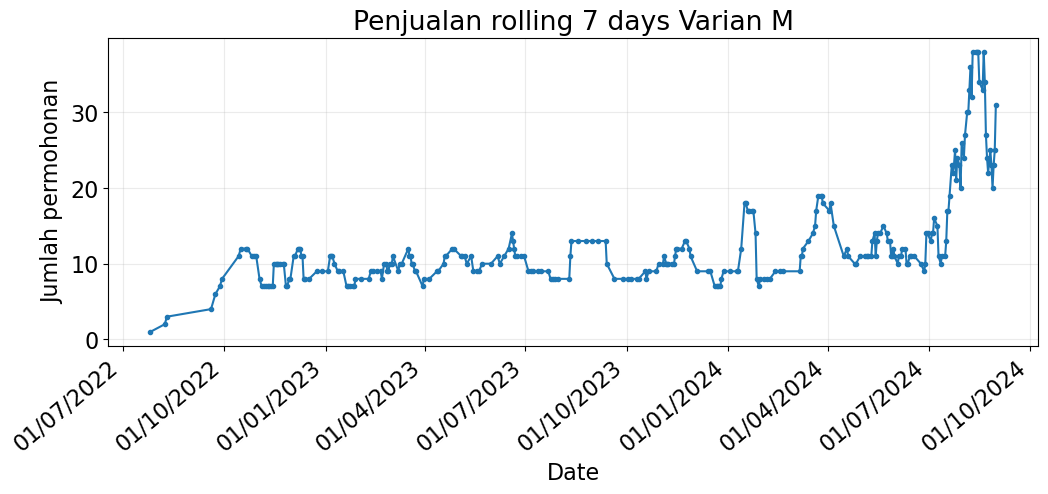

In [10]:
plot_time_series(df_M_count["Tgl. Mohon"], df_M_count["rolling_7days"], 
                title="Penjualan rolling 7 days Varian M",
                xlabel="Date", ylabel="Jumlah permohonan")

In [11]:
Q1 = df_M_count["rolling_7days"].quantile(0.25)
Q3 = df_M_count["rolling_7days"].quantile(0.75)
IQR = Q3 - Q1

batas_bawah = Q1 - 1.5 * IQR
batas_atas = Q3 + 1.5 * IQR

# Deteksi dan tampilkan outlier
outliers = df_M_count[(df_M_count["rolling_7days"] < batas_bawah) | 
                      (df_M_count["rolling_7days"] > batas_atas)]
print(f"Jumlah outlier (rolling_7days) varian M: {len(outliers)}")
display(outliers)


Jumlah outlier (rolling_7days) varian M: 35


,Tgl. Mohon,count,cumulative_sum,rolling_7days
0,2022-07-26,1,1,1.0
1,2022-08-08,1,2,2.0
255,2024-07-22,5,398,23.0
256,2024-07-23,1,399,22.0
257,2024-07-24,3,402,23.0
258,2024-07-25,5,407,25.0
259,2024-07-26,3,410,21.0
260,2024-07-27,4,414,24.0
261,2024-07-29,2,416,23.0
262,2024-07-30,2,418,20.0


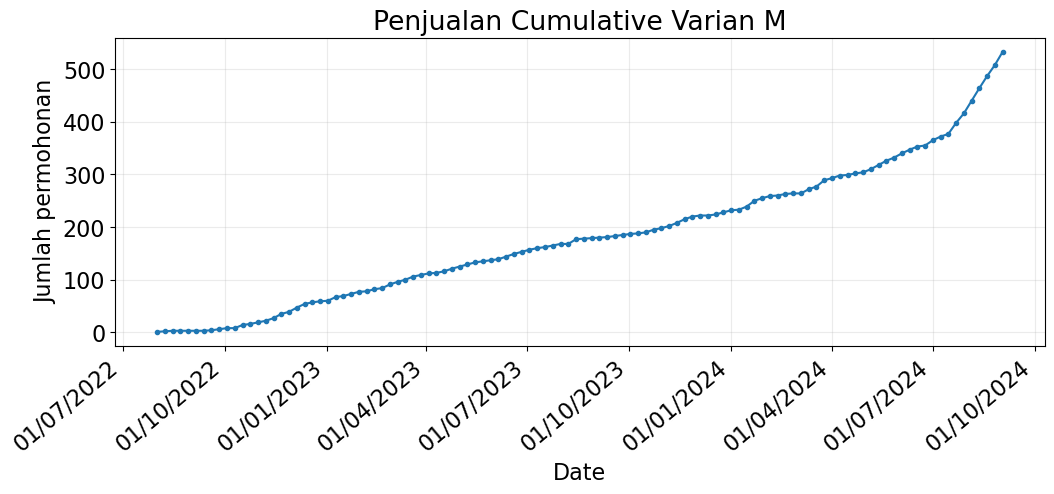

In [132]:
plot_time_series(df_M_weekly["Tgl. Mohon"], df_M_weekly["cumulative_sum"], 
                title="Penjualan Cumulative Varian M",
                xlabel="Date", ylabel="Jumlah permohonan")

#### weekly

In [133]:
ADF_result = adfuller(df_M_weekly["cumulative_sum"])
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: 0.929118037610138
p-value: 0.9934587984456482


first diff (_d_=1)

In [134]:
M_diff_week = np.diff(df_M_weekly["cumulative_sum"], n=1)
ADF_result = adfuller(M_diff_week)
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: 2.695370871497768
p-value: 0.9990867608734134


sec diff (_d_=2)

In [135]:
M_diff2_week = np.diff(M_diff_week, n=1)
ADF_result2 = adfuller(M_diff2_week)
print(f"ADF statistic : {ADF_result2[0]}")
print(f"p-value : {ADF_result2[1]}")

ADF statistic : -16.30269744850517
p-value : 3.254331433028201e-29


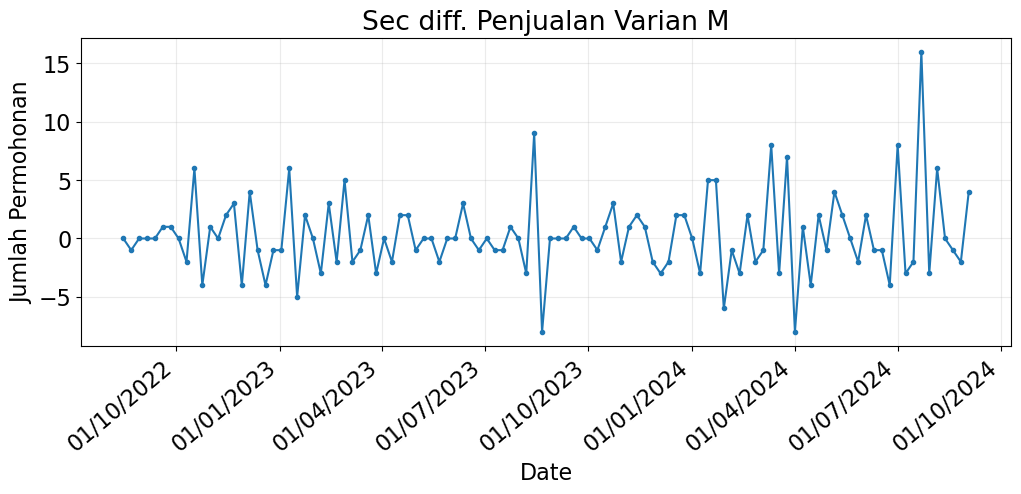

In [136]:
plot_time_series(df_M_weekly["Tgl. Mohon"].iloc[2:], M_diff2_week, 
                 title="Sec diff. Penjualan Varian M",
                 xlabel="Date", ylabel="Jumlah Permohonan")

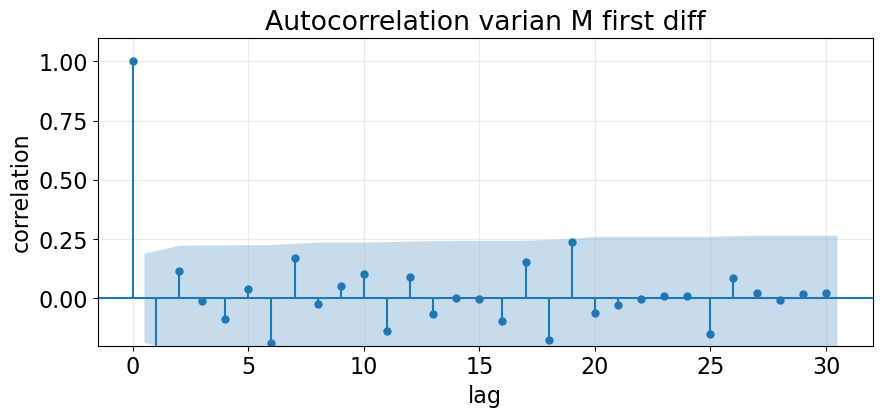

In [137]:
fig, ax = plt.subplots(figsize=(10, 4))

fig = plot_acf(M_diff2_week, lags=30, ax=ax)

ax.set_ylim([-.2, 1.1])
ax.set_ylabel("correlation")
ax.set_xlabel("lag")
ax.set_title("Autocorrelation varian M first diff")
ax.grid("on")

plt.show(fig)

#### harian

In [138]:
ADF_result = adfuller(df_M_count["rolling_7days"])
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: 0.7562294636695244
p-value: 0.9908957464332517


fisrt diff (_d_=1)

In [139]:
M_diff = np.diff(df_M_count["rolling_7days"], n=1)
ADF_result = adfuller(M_diff)
print(f"ADF statistic: {ADF_result[0]}")
print(F"p-value: {ADF_result[1]}")

ADF statistic: -6.729578078419931
p-value: 3.3222523835721204e-09


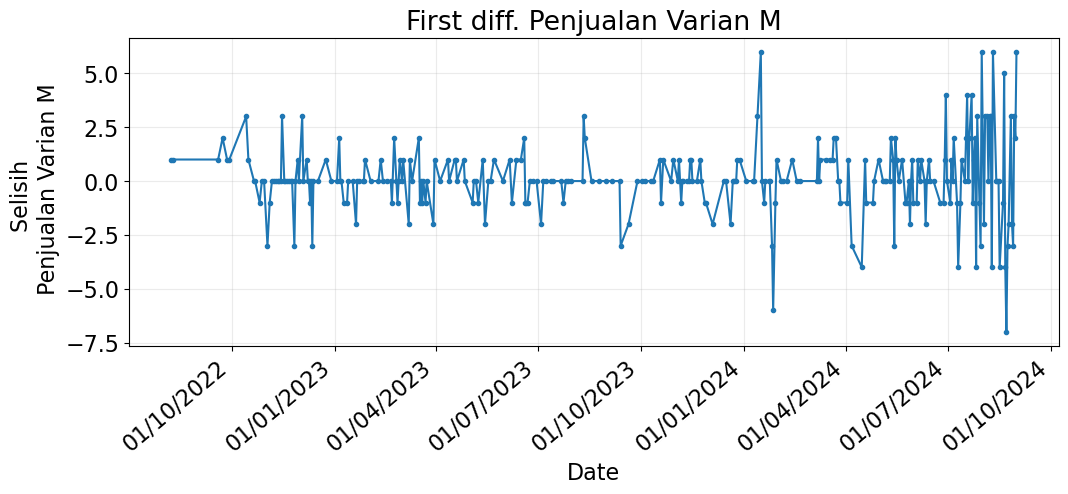

In [140]:
plot_time_series(df_M_count["Tgl. Mohon"].iloc[1:], M_diff, 
                 title="First diff. Penjualan Varian M",
                 xlabel="Date", ylabel="Selisih \n Penjualan Varian M")

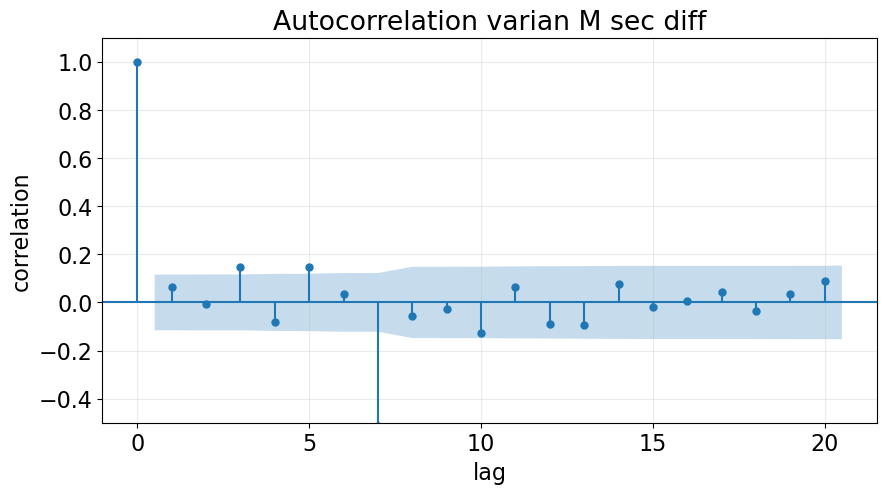

In [141]:
fig, ax = plt.subplots(figsize=(10, 5))

fig = plot_acf(M_diff, lags=20, ax=ax)

ax.set_ylim([-.5, 1.1])
ax.set_ylabel("correlation")
ax.set_xlabel("lag")
ax.set_title("Autocorrelation varian M sec diff")
ax.grid("on")

plt.show(fig)

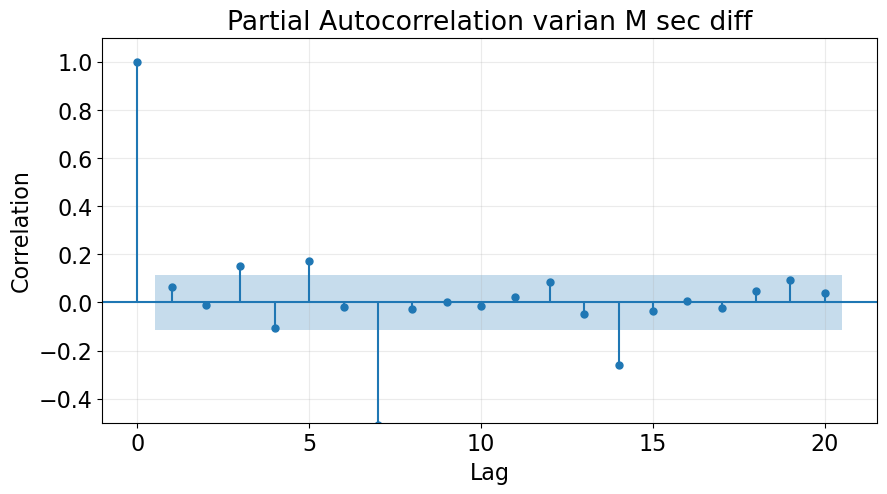

In [142]:
fig, ax = plt.subplots(figsize=(10, 5))

plot_pacf(M_diff, lags=20, ax=ax)

ax.set_ylim([-0.5, 1.1])
ax.set_ylabel("Correlation")
ax.set_xlabel("Lag")
ax.set_title("Partial Autocorrelation varian M sec diff")
ax.grid("on")

plt.show()

gaada lag yang signifikan pada acf dan pacf = random walk

### Data Splitting

In [143]:
min_length = min(len(df_M_count["Tgl. Mohon"].iloc[1:]), len(M_diff))

df_M_diff = pd.DataFrame({
    "Tgl. Mohon": df_M_count["Tgl. Mohon"].iloc[1:min_length+1].values,
    "M_diff": M_diff[:min_length]
})

split_idx = int(0.8 * len(df_M_diff))
df_train = df_M_diff.iloc[:split_idx].copy()
df_test = df_M_diff.iloc[split_idx:].copy()

print(f"(len(df_train), len(df_test)): {len(df_train), len(df_test)}")

(len(df_train), len(df_test)): (229, 58)


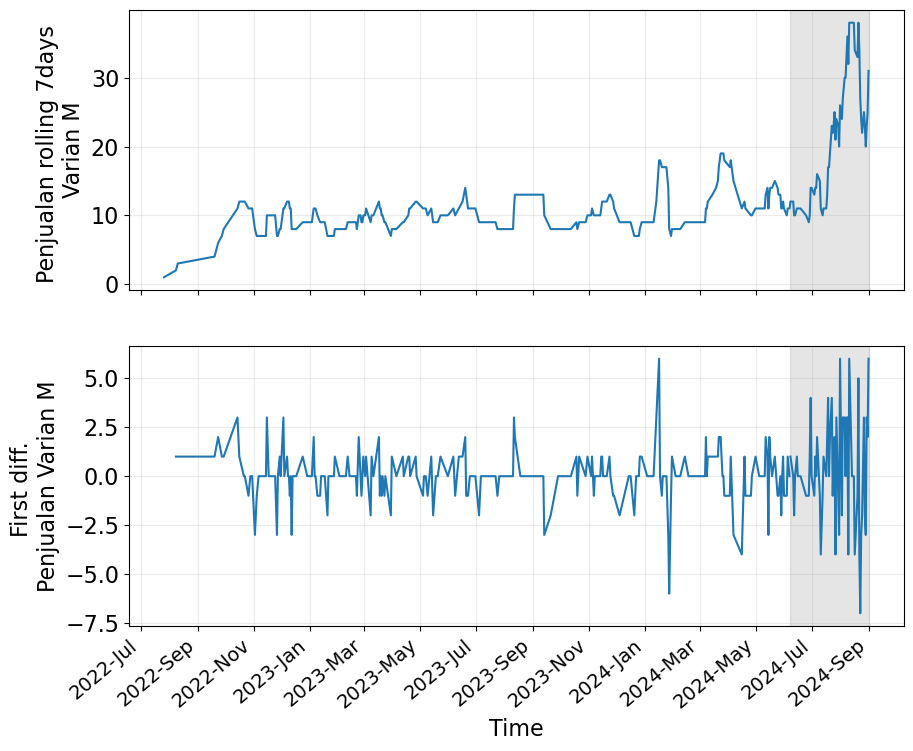

In [144]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))

# -- first row
axes[0].plot(df_M_count["Tgl. Mohon"], df_M_count["rolling_7days"])
axes[0].grid("on")
axes[0].set_ylabel("Penjualan rolling 7days \nVarian M")

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
axes[0].xaxis.set_major_formatter(formatter)
axes[0].xaxis.set_major_locator(locator)

# -- second row
axes[1].plot(df_train["Tgl. Mohon"], df_train["M_diff"])
axes[1].plot(df_test["Tgl. Mohon"], df_test["M_diff"], color="tab:blue")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("First diff. \nPenjualan Varian M")
axes[1].grid("on")

# add forecast area
for j in range(2):
  axes[j].axvspan(df_test["Tgl. Mohon"].iloc[0], df_test["Tgl. Mohon"].iloc[-1], 
                  color="#808080", alpha=0.2)

for j, label in enumerate(axes[1].get_xticklabels()):
  label.set_rotation(40)
  label.set_size(14)
  label.set_horizontalalignment('right')

plt.show(fig)

### Random Walk

Metode $\text{Drift}$ digunakan dalam _time series forecast_ dengan asumsi bahwa perubahan dari waktu ke waktu mengikuti tren linear. Metode ini untuk menangkap tren linier dalam data dan memberikan prediksi yang lebih baik dibandingkan metode rata-rata atau nilai terakhir ketika terdapat pola pertumbuhan atau penurunan yang konsisten. Berikut rumusnya:

$$
  \text{forecast} = \text{drift} \times \text{timestep} + y_i
$$

Keterangan:
- $ y_i $ adalah nilai awal
- $\text{drift}$ menunjukkan perubahan rata-rata per langkah waktu.

Drift dihitung sebagai kemiringan garis yang menghubungkan nilai awal $ y_i $ dengan nilai terakhir dalam data pelatihan $ y_f $:

$$
  \text{drift} = \text{slope} = \frac{h_y}{h_x} = \frac{y_f - y_i}{\text{\# timesteps} - 1}
$$

Dengan:
- $ h_y = y_f - y_i $ sebagai perubahan nilai antara titik awal dan titik akhir.
- $ h_x = \text{timesteps} - 1 $ sebagai selang waktu antara dua titik tersebut.

In [145]:
mean_train_random_walk = np.mean(df_train["M_diff"])
df_test["pred_mean"] = mean_train_random_walk

df_test.head()

,Tgl. Mohon,M_diff,pred_mean
229,2024-06-07,1.0,0.043668
230,2024-06-10,0.0,0.043668
231,2024-06-11,-2.0,0.043668
232,2024-06-12,0.0,0.043668
233,2024-06-14,1.0,0.043668


In [146]:
last_value = df_train.iloc[-1]["M_diff"]
df_test["pred_last"] = last_value

df_test.head()

,Tgl. Mohon,M_diff,pred_mean,pred_last
229,2024-06-07,1.0,0.043668,0.0
230,2024-06-10,0.0,0.043668,0.0
231,2024-06-11,-2.0,0.043668,0.0
232,2024-06-12,0.0,0.043668,0.0
233,2024-06-14,1.0,0.043668,0.0


In [147]:
y_i = df_train["M_diff"].iloc[0]
y_f = df_train["M_diff"].iloc[-1]
h_y = y_f - y_i
h_x = len(df_train) - 1
drift = h_y / h_x

print(f"drift = {drift}")

drift = -0.0043859649122807015


In [148]:
x_vals = np.arange(1, len(df_test) + 1)
df_test["pred_drift"] = drift * x_vals + y_i

df_test.head()

,Tgl. Mohon,M_diff,pred_mean,pred_last,pred_drift
229,2024-06-07,1.0,0.043668,0.0,0.995614
230,2024-06-10,0.0,0.043668,0.0,0.991228
231,2024-06-11,-2.0,0.043668,0.0,0.986842
232,2024-06-12,0.0,0.043668,0.0,0.982456
233,2024-06-14,1.0,0.043668,0.0,0.978070


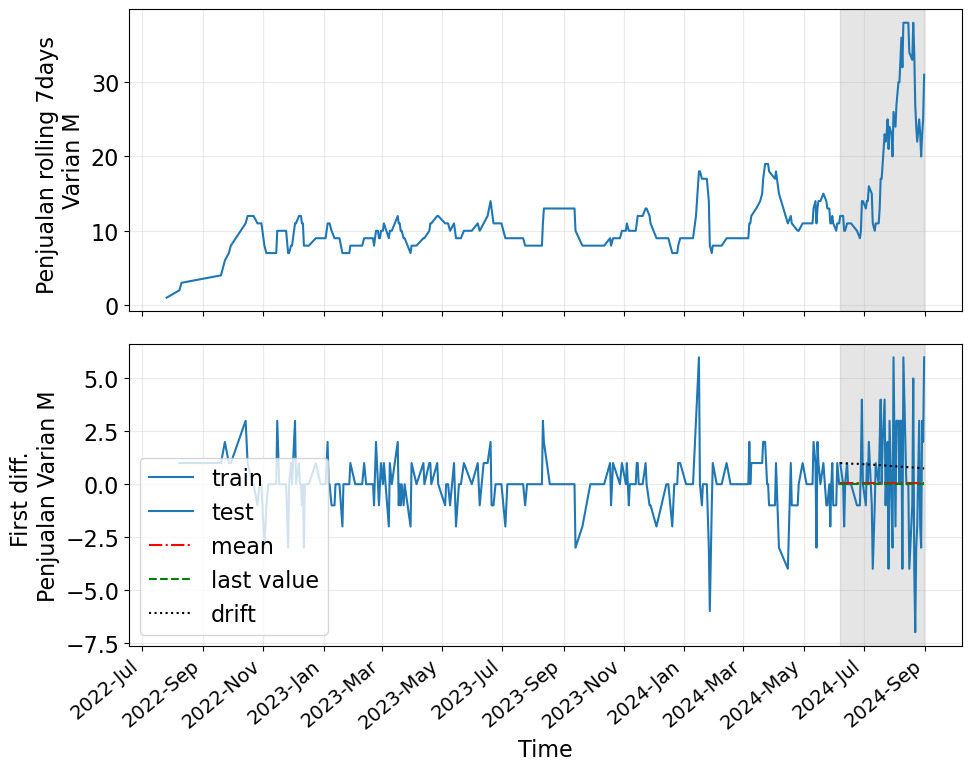

In [149]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))

# -- first row: rolling_7days
axes[0].plot(df_M_count["Tgl. Mohon"], df_M_count["rolling_7days"], label="rolling_7days")
axes[0].grid("on")
axes[0].set_ylabel("Penjualan rolling 7days \nVarian M")

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
axes[0].xaxis.set_major_formatter(formatter)
axes[0].xaxis.set_major_locator(locator)

# -- second row: M_diff + predictions
axes[1].plot(df_train["Tgl. Mohon"], df_train["M_diff"], label="train")
axes[1].plot(df_test["Tgl. Mohon"], df_test["M_diff"], color="tab:blue", label="test")
axes[1].plot(df_test["Tgl. Mohon"], df_test["pred_mean"], "r-.", label="mean")
axes[1].plot(df_test["Tgl. Mohon"], df_test["pred_last"], "g--", label="last value")
axes[1].plot(df_test["Tgl. Mohon"], df_test["pred_drift"], "k:", label="drift")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("First diff. \nPenjualan Varian M")
axes[1].grid("on")
axes[1].legend()

# add forecast area
for j in range(2):
    axes[j].axvspan(df_test["Tgl. Mohon"].iloc[0], df_test["Tgl. Mohon"].iloc[-1], 
                    color="#808080", alpha=0.2)

# rotate labels
for j, label in enumerate(axes[1].get_xticklabels()):
    label.set_rotation(40)
    label.set_size(14)
    label.set_horizontalalignment('right')

plt.tight_layout()
plt.show(fig)


In [150]:
# Ambil nilai rolling_7days terakhir dari data latih
last_rolling_train = df_M_count["rolling_7days"].iloc[len(df_train)]

# Tambahkan hasil forecast asli (bukan differencing)
df_test["forecast_mean"]  = last_rolling_train + df_test["pred_mean"].cumsum()
df_test["forecast_last"]  = last_rolling_train + df_test["pred_last"].cumsum()
df_test["forecast_drift"] = last_rolling_train + df_test["pred_drift"].cumsum()

# Gabungkan nilai aktual rolling_7days
df_test = df_test.merge(df_M_count[["Tgl. Mohon", "rolling_7days"]], on="Tgl. Mohon", how="left")


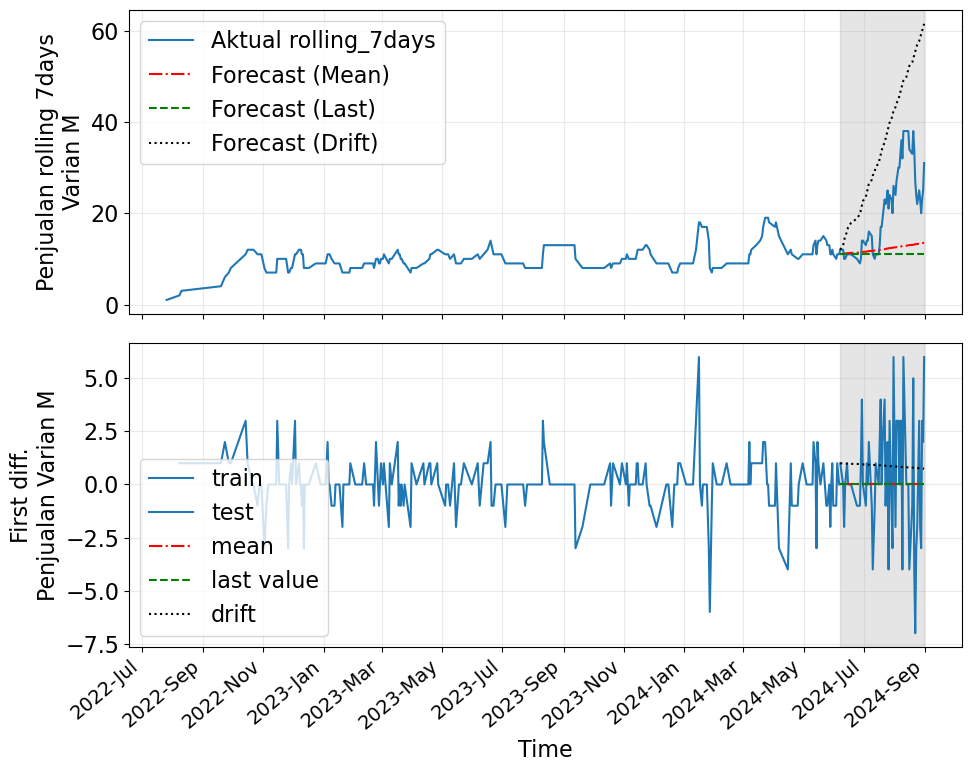

In [151]:
fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10, 8))

# -- subplot 1: rolling_7days aktual + hasil forecast
axes[0].plot(df_M_count["Tgl. Mohon"], df_M_count["rolling_7days"], label="Aktual rolling_7days")
axes[0].plot(df_test["Tgl. Mohon"], df_test["forecast_mean"], "r-.", label="Forecast (Mean)")
axes[0].plot(df_test["Tgl. Mohon"], df_test["forecast_last"], "g--", label="Forecast (Last)")
axes[0].plot(df_test["Tgl. Mohon"], df_test["forecast_drift"], "k:", label="Forecast (Drift)")
axes[0].set_ylabel("Penjualan rolling 7days\nVarian M")
axes[0].legend()
axes[0].grid(True)

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
axes[0].xaxis.set_major_formatter(formatter)
axes[0].xaxis.set_major_locator(locator)

# -- subplot 2: M_diff dan prediksi differenced
axes[1].plot(df_train["Tgl. Mohon"], df_train["M_diff"], label="train")
axes[1].plot(df_test["Tgl. Mohon"], df_test["M_diff"], color="tab:blue", label="test")
axes[1].plot(df_test["Tgl. Mohon"], df_test["pred_mean"], "r-.", label="mean")
axes[1].plot(df_test["Tgl. Mohon"], df_test["pred_last"], "g--", label="last value")
axes[1].plot(df_test["Tgl. Mohon"], df_test["pred_drift"], "k:", label="drift")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("First diff.\nPenjualan Varian M")
axes[1].grid(True)
axes[1].legend()

# -- shading area test
for ax in axes:
    ax.axvspan(df_test["Tgl. Mohon"].iloc[0], df_test["Tgl. Mohon"].iloc[-1], 
               color="#808080", alpha=0.2)

# -- format x-axis
for label in axes[1].get_xticklabels():
    label.set_rotation(40)
    label.set_size(14)
    label.set_horizontalalignment('right')

plt.tight_layout()
plt.show()


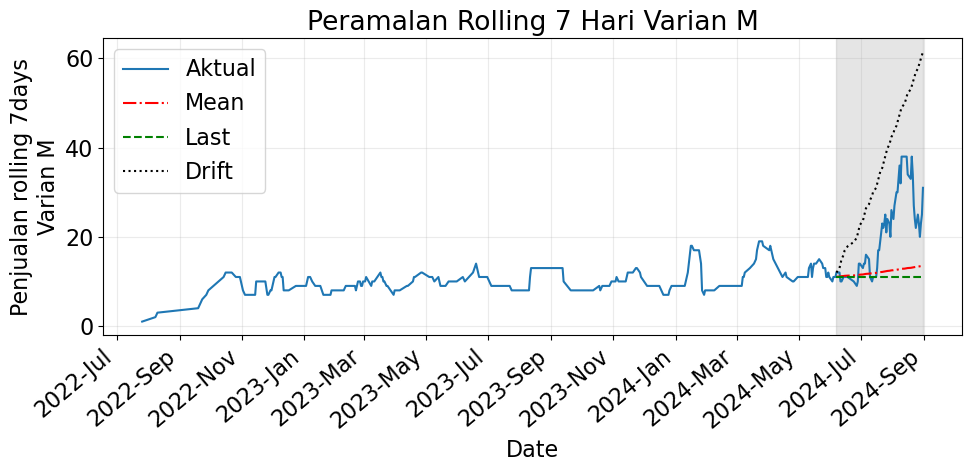

In [154]:
fig, ax = plt.subplots(figsize=(10, 5))  # hanya satu subplot

# -- Plot aktual dan hasil forecast rolling_7days
ax.plot(df_M_count["Tgl. Mohon"], df_M_count["rolling_7days"], label="Aktual")
ax.plot(df_test["Tgl. Mohon"], df_test["forecast_mean"], "r-.", label="Mean")
ax.plot(df_test["Tgl. Mohon"], df_test["forecast_last"], "g--", label="Last")
ax.plot(df_test["Tgl. Mohon"], df_test["forecast_drift"], "k:", label="Drift")
ax.set_ylabel("Penjualan rolling 7days\nVarian M")
ax.set_title("Peramalan Rolling 7 Hari Varian M")
ax.set_xlabel("Date")
ax.legend()
ax.grid(True)

# Format x-axis
formatter = mdates.DateFormatter("%Y-%b")
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)

# Highlight test area
ax.axvspan(df_test["Tgl. Mohon"].iloc[0], df_test["Tgl. Mohon"].iloc[-1], 
           color="#808080", alpha=0.2)

# Rotate x-axis labels
for label in ax.get_xticklabels():
    label.set_rotation(40)
    # label.set_size(12)
    label.set_horizontalalignment('right')

plt.tight_layout()
plt.show()


### Evaluasi

In [70]:
mae_pred_mean  = mean_absolute_error(df_test["rolling_7days"], df_test["forecast_mean"])
mae_pred_last  = mean_absolute_error(df_test["rolling_7days"], df_test["forecast_last"])
mae_pred_drift = mean_absolute_error(df_test["rolling_7days"], df_test["forecast_drift"])

print(f"MAE mean:  {mae_pred_mean:.2f}")
print(f"MAE last:  {mae_pred_last:.2f}")
print(f"MAE drift: {mae_pred_drift:.2f}")

MAE mean:  9.61
MAE last:  10.71
MAE drift: 16.45


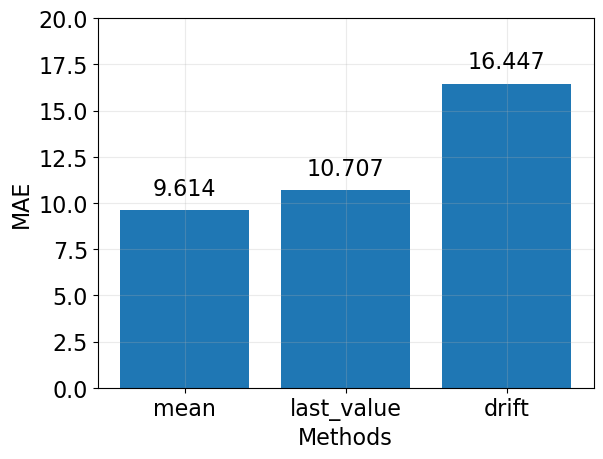

In [71]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "drift"]
y_array = [mae_pred_mean, mae_pred_last, mae_pred_drift]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MAE")
ax.set_ylim([0, 20])

for idx, val in enumerate(y_array):
  ax.text(idx, val + (max(y_array) * 0.05), s=f"{val:.3f}", ha="center")

plt.show(fig)

In [72]:
mse_pred_mean  = mean_squared_error(df_test["rolling_7days"], df_test["forecast_mean"])
mse_pred_last  = mean_squared_error(df_test["rolling_7days"], df_test["forecast_last"])
mse_pred_drift = mean_squared_error(df_test["rolling_7days"], df_test["forecast_drift"])

print(f"MSE mean:  {mse_pred_mean:.2f}")
print(f"MSE last:  {mse_pred_last:.2f}")
print(f"MSE drift: {mse_pred_drift:.2f}")

MSE mean:  156.77
MSE last:  192.19
MSE drift: 350.94


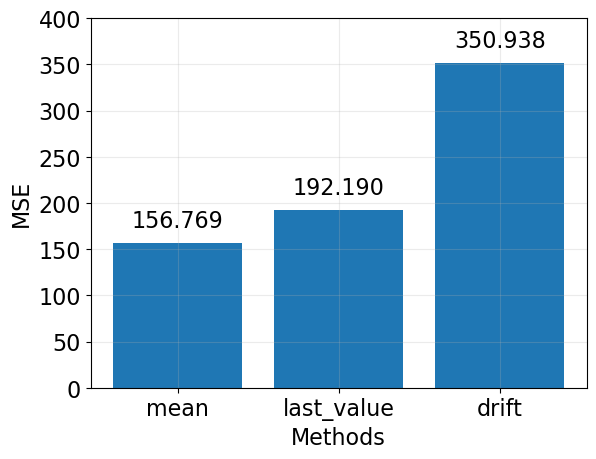

In [73]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "drift"]
y_array = [mse_pred_mean, mse_pred_last, mse_pred_drift]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MSE")
ax.set_ylim([0, 400])

for idx, val in enumerate(y_array):
  ax.text(idx, val + (max(y_array) * 0.05), s=f"{val:.3f}", ha="center")

plt.show(fig)

RMSE

In [74]:
rmse_pred_mean  = np.sqrt(mse_pred_mean)
rmse_pred_last  = np.sqrt(mse_pred_last)
rmse_pred_drift = np.sqrt(mse_pred_drift)

print(f"RMSE mean:  {rmse_pred_mean:.2f}")
print(f"RMSE last:  {rmse_pred_last:.2f}")
print(f"RMSE drift: {rmse_pred_drift:.2f}")

RMSE mean:  12.52
RMSE last:  13.86
RMSE drift: 18.73


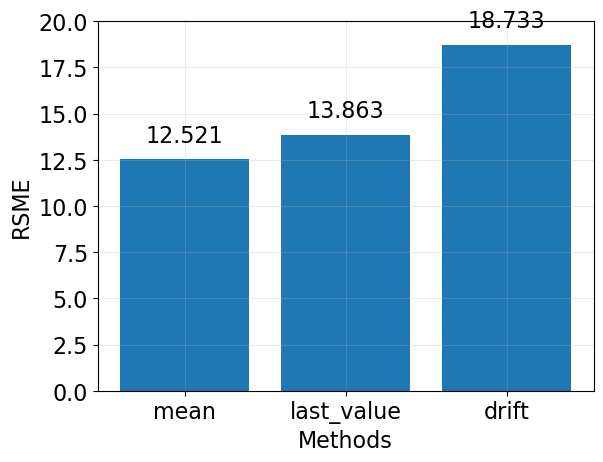

In [75]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "drift"]
y_array = [rmse_pred_mean, rmse_pred_last, rmse_pred_drift]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("RSME")
ax.set_ylim([0, 20])

for idx, val in enumerate(y_array):
  ax.text(idx, val + (max(y_array) * 0.05), s=f"{val:.3f}", ha="center")

plt.show(fig)

In [79]:
mape_pred_mean  = mean_absolute_percentage_error(df_test["rolling_7days"], df_test["forecast_mean"]) * 100
mape_pred_last  = mean_absolute_percentage_error(df_test["rolling_7days"], df_test["forecast_last"]) * 100
mape_pred_drift = mean_absolute_percentage_error(df_test["rolling_7days"], df_test["forecast_drift"]) * 100

print(f"MAPE mean:  {mape_pred_mean:.2f}%")
print(f"MAPE last:  {mape_pred_last:.2f}%")
print(f"MAPE drift: {mape_pred_drift:.2f}%")

MAPE mean:  36.33%
MAPE last:  40.20%
MAPE drift: 83.26%


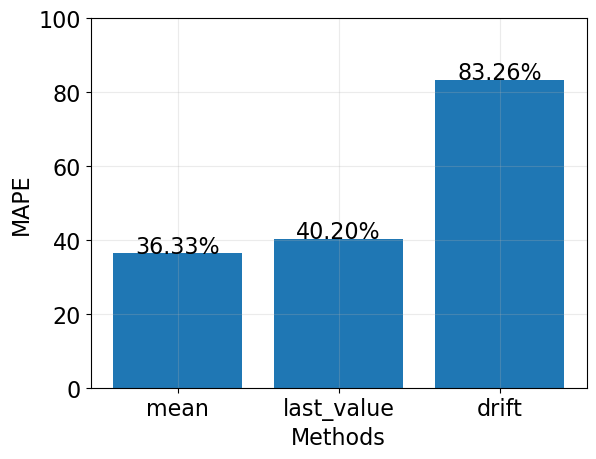

In [80]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "drift"]
y_array = [mape_pred_mean, mape_pred_last, mape_pred_drift]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MAPE")
ax.set_ylim([0, 100])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}%", ha="center")

plt.show(fig)

MASE

In [81]:
mase_pred_mean  = mae_pred_mean / naive
mase_pred_last  = mae_pred_last / naive
mase_pred_drift = mae_pred_drift / naive

print(f"MASE mean:  {mase_pred_mean:.2f}")
print(f"MASE last:  {mase_pred_last:.2f}")
print(f"MASE drift: {mase_pred_drift:.2f}")

NameError: name 'naive' is not defined

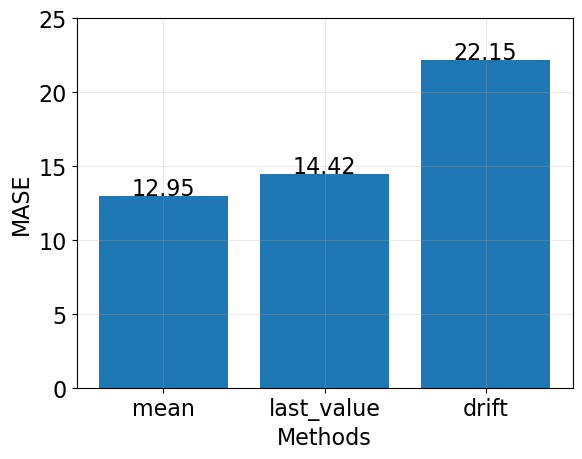

In [ ]:
fig, ax = plt.subplots()

x_array = ["mean", "last_value", "drift"]
y_array = [mase_pred_mean, mase_pred_last, mase_pred_drift]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MASE")
ax.set_ylim([0, 25])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.1, s=f"{val:.2f}", ha="center")

plt.show(fig)

In [82]:
advanced_decomposition = STL(df_M_count["rolling_7days"], period=12).fit()
advanced_decomposition

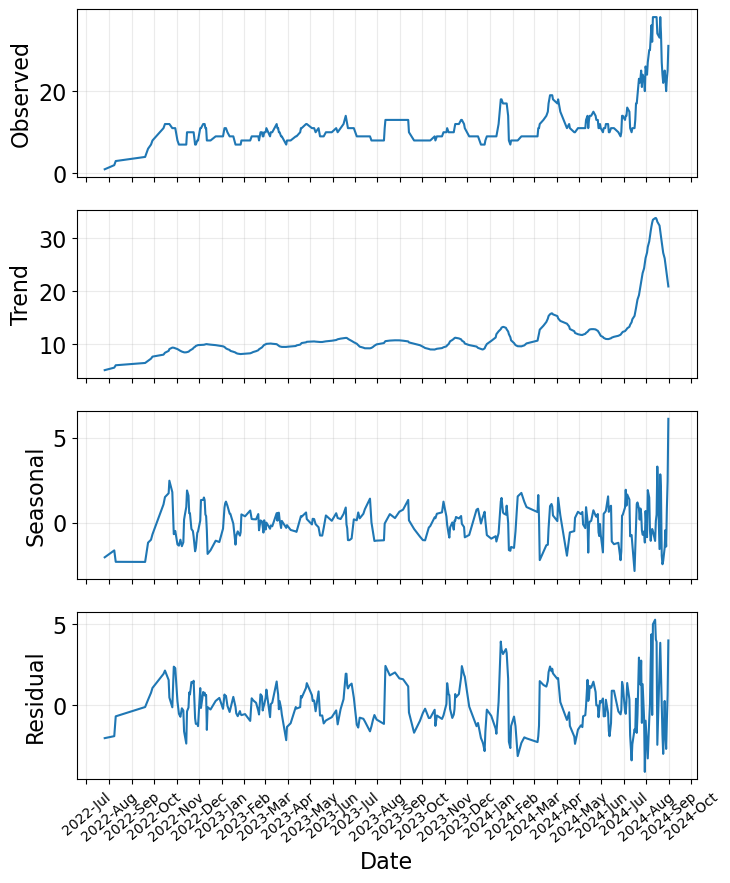

In [83]:
fig, axes = plt.subplots(nrows=4, figsize=(8, 10), sharex=True)

axes[0].plot(df_M_count["Tgl. Mohon"], advanced_decomposition.observed)
axes[1].plot(df_M_count["Tgl. Mohon"], advanced_decomposition.trend)
axes[2].plot(df_M_count["Tgl. Mohon"], advanced_decomposition.seasonal)
axes[3].plot(df_M_count["Tgl. Mohon"], advanced_decomposition.resid)

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))
axes[3].xaxis.set_major_formatter(formatter)
axes[3].xaxis.set_major_locator(locator)

for label in axes[3].get_xticklabels():
  label.set_rotation(40)
  label.set_size(10)

axes[0].set_ylabel("Observed")
axes[1].set_ylabel("Trend")
axes[2].set_ylabel("Seasonal")
axes[3].set_ylabel("Residual")
axes[3].set_xlabel("Date")

for ax in axes:
  ax.grid("on")

plt.show(fig)

### Data Splitting

In [84]:
split_idx = int(0.8 * len(df_M_count))
df_train = df_M_count.iloc[:split_idx].copy()
df_test = df_M_count.iloc[split_idx:].copy()

print(f"(len(df_train), len(df_test)): {len(df_train), len(df_test)}")

(len(df_train), len(df_test)): (230, 58)


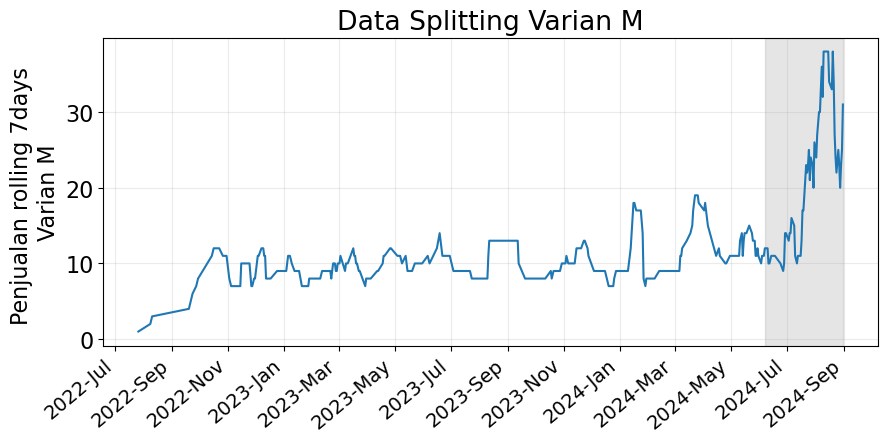

In [85]:
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(df_M_count['Tgl. Mohon'], df_M_count["rolling_7days"])
ax.grid("on")
ax.set_ylabel("Penjualan rolling 7days \nVarian M")
ax.set_title("Data Splitting Varian M")

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)

# add forecast area
ax.axvspan(df_test['Tgl. Mohon'].iloc[0], df_test['Tgl. Mohon'].iloc[-1], 
                color="#808080", alpha=0.2)

for j, label in enumerate(ax.get_xticklabels()):
  label.set_rotation(40)
  label.set_size(14)
  label.set_horizontalalignment('right')

plt.show(fig)

### ARIMA (1,1,2)

In [86]:
p_space = range(0, 13, 1)  # set 0 to 12 to capture seasonal information
q_space = range(0, 13, 1)
P_space = [0]   # set P and Q to 0 because we are working with ARIMA(p,d,q)
Q_space = [0]

d = 1
D = 0   # set D = 0, because we are working with ARIMA(p,d,q)
m = 12

arima_order_list = list(itertls.product(p_space, q_space, P_space, Q_space))
print(f"num. of possible paramters setting: {len(arima_order_list)}")
arima_order_list

num. of possible paramters setting: 169


[(0, 0, 0, 0),
 (0, 1, 0, 0),
 (0, 2, 0, 0),
 (0, 3, 0, 0),
 (0, 4, 0, 0),
 (0, 5, 0, 0),
 (0, 6, 0, 0),
 (0, 7, 0, 0),
 (0, 8, 0, 0),
 (0, 9, 0, 0),
 (0, 10, 0, 0),
 (0, 11, 0, 0),
 (0, 12, 0, 0),
 (1, 0, 0, 0),
 (1, 1, 0, 0),
 (1, 2, 0, 0),
 (1, 3, 0, 0),
 (1, 4, 0, 0),
 (1, 5, 0, 0),
 (1, 6, 0, 0),
 (1, 7, 0, 0),
 (1, 8, 0, 0),
 (1, 9, 0, 0),
 (1, 10, 0, 0),
 (1, 11, 0, 0),
 (1, 12, 0, 0),
 (2, 0, 0, 0),
 (2, 1, 0, 0),
 (2, 2, 0, 0),
 (2, 3, 0, 0),
 (2, 4, 0, 0),
 (2, 5, 0, 0),
 (2, 6, 0, 0),
 (2, 7, 0, 0),
 (2, 8, 0, 0),
 (2, 9, 0, 0),
 (2, 10, 0, 0),
 (2, 11, 0, 0),
 (2, 12, 0, 0),
 (3, 0, 0, 0),
 (3, 1, 0, 0),
 (3, 2, 0, 0),
 (3, 3, 0, 0),
 (3, 4, 0, 0),
 (3, 5, 0, 0),
 (3, 6, 0, 0),
 (3, 7, 0, 0),
 (3, 8, 0, 0),
 (3, 9, 0, 0),
 (3, 10, 0, 0),
 (3, 11, 0, 0),
 (3, 12, 0, 0),
 (4, 0, 0, 0),
 (4, 1, 0, 0),
 (4, 2, 0, 0),
 (4, 3, 0, 0),
 (4, 4, 0, 0),
 (4, 5, 0, 0),
 (4, 6, 0, 0),
 (4, 7, 0, 0),
 (4, 8, 0, 0),
 (4, 9, 0, 0),
 (4, 10, 0, 0),
 (4, 11, 0, 0),
 (4, 12, 0, 0),
 (5, 0, 0,

In [87]:
def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, 
                    D: int, m: int,
                    enforce_stationarity: bool=True, 
                    enforce_invertibility: bool=True) -> pd.DataFrame:

  result = []
  # warnings.filterwarnings("error")   # handling warnings as error
  # warnings.resetwarnings()     # to reset warnings

  for order in notebook.tqdm(order_list):
    # print(f"{(order[0], order[1])}")
    try:
      model = SARIMAX(endog, order=(order[0], d, order[1]), 
                      seasonal_order=(order[2], D, order[3], m), 
                      simple_differencing=False, 
                      enforce_invertibility=enforce_invertibility,
                      enforce_stationarity=enforce_stationarity).fit(disp=False)
    except:
      continue

    aic = model.aic
    result.append([order, aic])

  
  result_df = pd.DataFrame(result)
  # print(result_df.columns)
  result_df.columns = ["(p,q,P,Q)", "AIC"]

  # Sort in ascending order, lower AIC is better
  result_df = result_df.sort_values(by="AIC", ascending=True).reset_index(drop=True)

  return result_df

In [88]:
# Computational time: 4m 30.0s
# arima_result_df = optimize_SARIMA(df_train["rolling_7days"], arima_order_list, d,
#                            D, m, enforce_invertibility=True, enforce_stationarity=True)

In [89]:
# arima_result_df.to_csv("./data/varian-m-arima-result.csv", index=False)

In [90]:
reload_arima_result_df = pd.read_csv("./data/varian-m-arima-result.csv")
reload_arima_result_df

,"(p,q,P,Q)",AIC
0,"(7, 11, 0, 0)",624.620745
1,"(1, 7, 0, 0)",625.909572
2,"(0, 8, 0, 0)",625.929241
3,"(6, 11, 0, 0)",626.528269
4,"(2, 7, 0, 0)",627.919065
...,...,...
164,"(3, 1, 0, 0)",749.951837
165,"(2, 2, 0, 0)",750.361061
166,"(5, 0, 0, 0)",751.473240
167,"(0, 0, 0, 0)",751.620503


In [91]:
# arima_result_df
reload_arima_result_df

,"(p,q,P,Q)",AIC
0,"(7, 11, 0, 0)",624.620745
1,"(1, 7, 0, 0)",625.909572
2,"(0, 8, 0, 0)",625.929241
3,"(6, 11, 0, 0)",626.528269
4,"(2, 7, 0, 0)",627.919065
...,...,...
164,"(3, 1, 0, 0)",749.951837
165,"(2, 2, 0, 0)",750.361061
166,"(5, 0, 0, 0)",751.473240
167,"(0, 0, 0, 0)",751.620503


In [92]:
# best_pqPQ = reload_arima_result_df["(p,q,P,Q)"].iloc[1]
# best_arima_p, best_arima_q, _, _ = tuple(map(int, best_pqPQ.strip("()").split(", ")))
# print(f"best ARIMA (p,q): {(best_arima_p, best_arima_q)}")

In [93]:
best_arima_p, best_arima_q = (4, 11)
print(f"best ARIMA (p,q): {(best_arima_p, best_arima_q)}")

best ARIMA (p,q): (4, 11)


In [94]:
model_arima_best = SARIMAX(df_train["rolling_7days"], order=(best_arima_p, d, best_arima_q), 
                        simple_differencing=False)
model_arima_best_fit = model_arima_best.fit(disp=False)

c:\ProgramData\miniconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


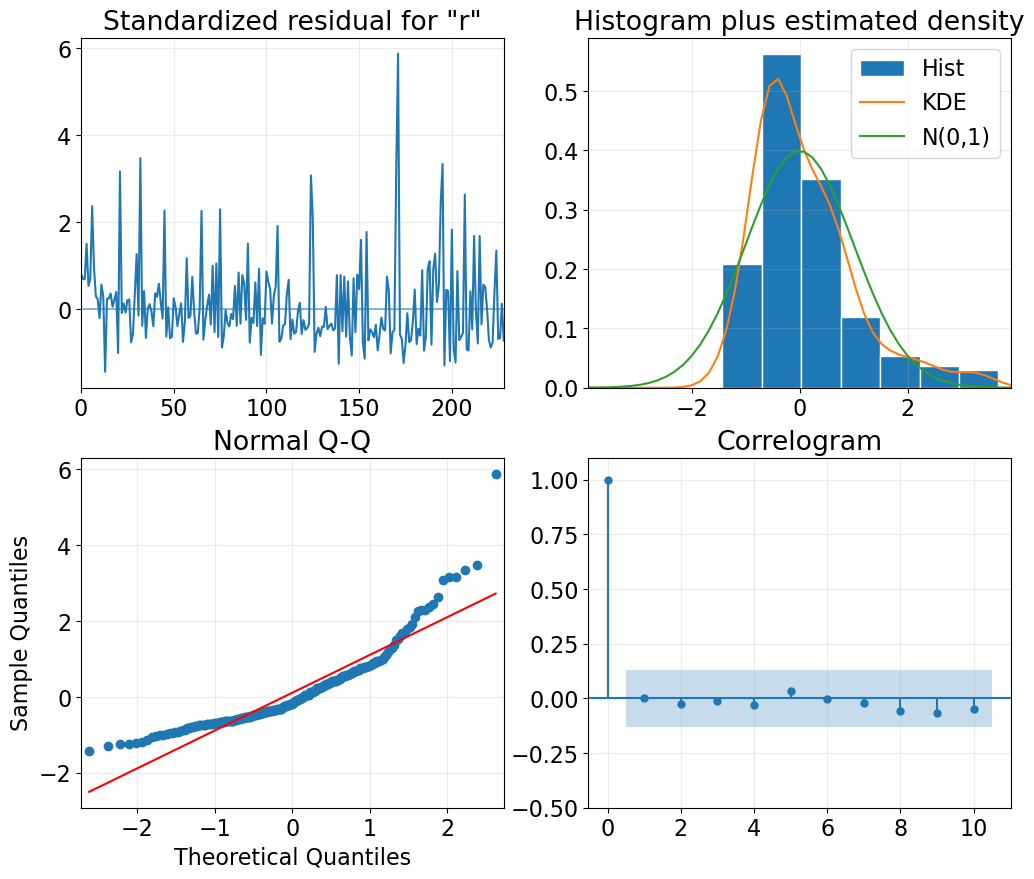

In [95]:
fig = model_arima_best_fit.plot_diagnostics(figsize=(12, 10))

# get all axes
axs = fig.get_axes()
for ax in axs:
  ax.grid("on")

# set y-lim for correlogram plot
axs[3].set_ylim([-0.5, 1.1])
plt.show(fig)

In [96]:
residuals = model_arima_best_fit.resid
ljung_box_test = acorr_ljungbox(residuals, np.arange(1, 11))
ljung_box_test

,lb_stat,lb_pvalue
1,0.107092,0.743479
2,0.107770,0.947541
3,0.139528,0.986704
4,0.152624,0.997232
5,0.598458,0.988074
6,0.618786,0.996079
7,0.650787,0.998686
8,1.240977,0.996220
9,2.008475,0.991333
10,2.498313,0.990900


- Pada semua lag nilai p-value lebih besar dari 0.05, maka kita tidak reject the null hypothesis pada setiap lag.
- Artinya residual bersifat independen dan tidak berkorelasi, sehingga residual dari model ARIMA dianggap sebagai white noise dan model sudah cukup baik dalam menangkap pola data.

In [97]:
df_test_pred = df_test.copy()

TRAIN_LEN = len(df_train)
HORIZON = len(df_test)

pred_naive_seasonal = df_train["rolling_7days"].iloc[-HORIZON:].values
pred_arima = model_arima_best_fit.get_prediction(
  TRAIN_LEN, TRAIN_LEN + HORIZON - 1).predicted_mean

df_test_pred["pred_naive_seasonal"] = pred_naive_seasonal
df_test_pred["pred_arima"] = pred_arima

df_test_pred.head()

,Tgl. Mohon,count,cumulative_sum,rolling_7days,pred_naive_seasonal,pred_arima
230,2024-06-07,2,345,12.0,18.0,11.541875
231,2024-06-10,2,347,12.0,18.0,11.642842
232,2024-06-11,1,348,10.0,17.0,10.241801
233,2024-06-12,1,349,10.0,17.0,10.714120
234,2024-06-14,2,351,11.0,17.0,11.564678


### SARIMA

In [98]:
p_space = range(0, 4, 1)  
q_space = range(0, 4, 1)
P_space = range(0, 4, 1)   
Q_space = range(0, 4, 1)

d = 1
D = 1   
m = 12

sarima_order_list = list(itertls.product(p_space, q_space, P_space, Q_space))
print(f"num. of possible paramters setting: {len(sarima_order_list)}")
sarima_order_list

num. of possible paramters setting: 256


[(0, 0, 0, 0),
 (0, 0, 0, 1),
 (0, 0, 0, 2),
 (0, 0, 0, 3),
 (0, 0, 1, 0),
 (0, 0, 1, 1),
 (0, 0, 1, 2),
 (0, 0, 1, 3),
 (0, 0, 2, 0),
 (0, 0, 2, 1),
 (0, 0, 2, 2),
 (0, 0, 2, 3),
 (0, 0, 3, 0),
 (0, 0, 3, 1),
 (0, 0, 3, 2),
 (0, 0, 3, 3),
 (0, 1, 0, 0),
 (0, 1, 0, 1),
 (0, 1, 0, 2),
 (0, 1, 0, 3),
 (0, 1, 1, 0),
 (0, 1, 1, 1),
 (0, 1, 1, 2),
 (0, 1, 1, 3),
 (0, 1, 2, 0),
 (0, 1, 2, 1),
 (0, 1, 2, 2),
 (0, 1, 2, 3),
 (0, 1, 3, 0),
 (0, 1, 3, 1),
 (0, 1, 3, 2),
 (0, 1, 3, 3),
 (0, 2, 0, 0),
 (0, 2, 0, 1),
 (0, 2, 0, 2),
 (0, 2, 0, 3),
 (0, 2, 1, 0),
 (0, 2, 1, 1),
 (0, 2, 1, 2),
 (0, 2, 1, 3),
 (0, 2, 2, 0),
 (0, 2, 2, 1),
 (0, 2, 2, 2),
 (0, 2, 2, 3),
 (0, 2, 3, 0),
 (0, 2, 3, 1),
 (0, 2, 3, 2),
 (0, 2, 3, 3),
 (0, 3, 0, 0),
 (0, 3, 0, 1),
 (0, 3, 0, 2),
 (0, 3, 0, 3),
 (0, 3, 1, 0),
 (0, 3, 1, 1),
 (0, 3, 1, 2),
 (0, 3, 1, 3),
 (0, 3, 2, 0),
 (0, 3, 2, 1),
 (0, 3, 2, 2),
 (0, 3, 2, 3),
 (0, 3, 3, 0),
 (0, 3, 3, 1),
 (0, 3, 3, 2),
 (0, 3, 3, 3),
 (1, 0, 0, 0),
 (1, 0, 0, 1),
 (1, 0, 0,

In [99]:
# Computational time: 17m 38.8s
# sarima_result_df = optimize_SARIMA(df_train["rolling_7days"], sarima_order_list, d,
#                           D, m, enforce_invertibility=True, enforce_stationarity=True)

In [100]:
# sarima_result_df.to_csv("./data/varian-m-sarima-result.csv", index=False)

In [101]:
reload_sarima_result_df = pd.read_csv("./data/varian-m-sarima-result.csv")
reload_sarima_result_df

,"(p,q,P,Q)",AIC
0,"(3, 2, 0, 3)",708.697584
1,"(3, 2, 0, 1)",709.132211
2,"(3, 2, 2, 1)",709.198785
3,"(3, 2, 1, 3)",709.757933
4,"(3, 2, 3, 1)",709.828375
...,...,...
251,"(1, 2, 0, 0)",850.296911
252,"(3, 0, 0, 0)",850.637471
253,"(0, 1, 0, 0)",851.424439
254,"(3, 1, 0, 0)",852.082144


In [102]:
# sarima_result_df
reload_sarima_result_df

,"(p,q,P,Q)",AIC
0,"(3, 2, 0, 3)",708.697584
1,"(3, 2, 0, 1)",709.132211
2,"(3, 2, 2, 1)",709.198785
3,"(3, 2, 1, 3)",709.757933
4,"(3, 2, 3, 1)",709.828375
...,...,...
251,"(1, 2, 0, 0)",850.296911
252,"(3, 0, 0, 0)",850.637471
253,"(0, 1, 0, 0)",851.424439
254,"(3, 1, 0, 0)",852.082144


In [103]:
# best_pqPQ = reload_sarima_result_df["(p,q,P,Q)"].iloc[0]
# best_sarima_p, best_sarima_q, best_sarima_P, best_sarima_Q \
#   = tuple(map(int, best_pqPQ.strip("()").split(", ")))
# print(f"best SARIMA (p,q,P,Q): {(best_sarima_p, best_sarima_q, best_sarima_P, best_sarima_Q)}")

In [104]:
best_sarima_p, best_sarima_q, best_sarima_P, best_sarima_Q \
  = (1, 3, 1, 1)
print(f"best SARIMA (p,q,P,Q): {(best_sarima_p, best_sarima_q, best_sarima_P, best_sarima_Q)}")

best SARIMA (p,q,P,Q): (1, 3, 1, 1)


In [105]:
model_sarima_best = SARIMAX(df_train["rolling_7days"], order=(best_sarima_p, d, best_sarima_q), 
                            seasonal_order=(best_sarima_P, D, best_sarima_Q, m),
                            simple_differencing=False)
model_sarima_best_fit = model_sarima_best.fit(disp=False)

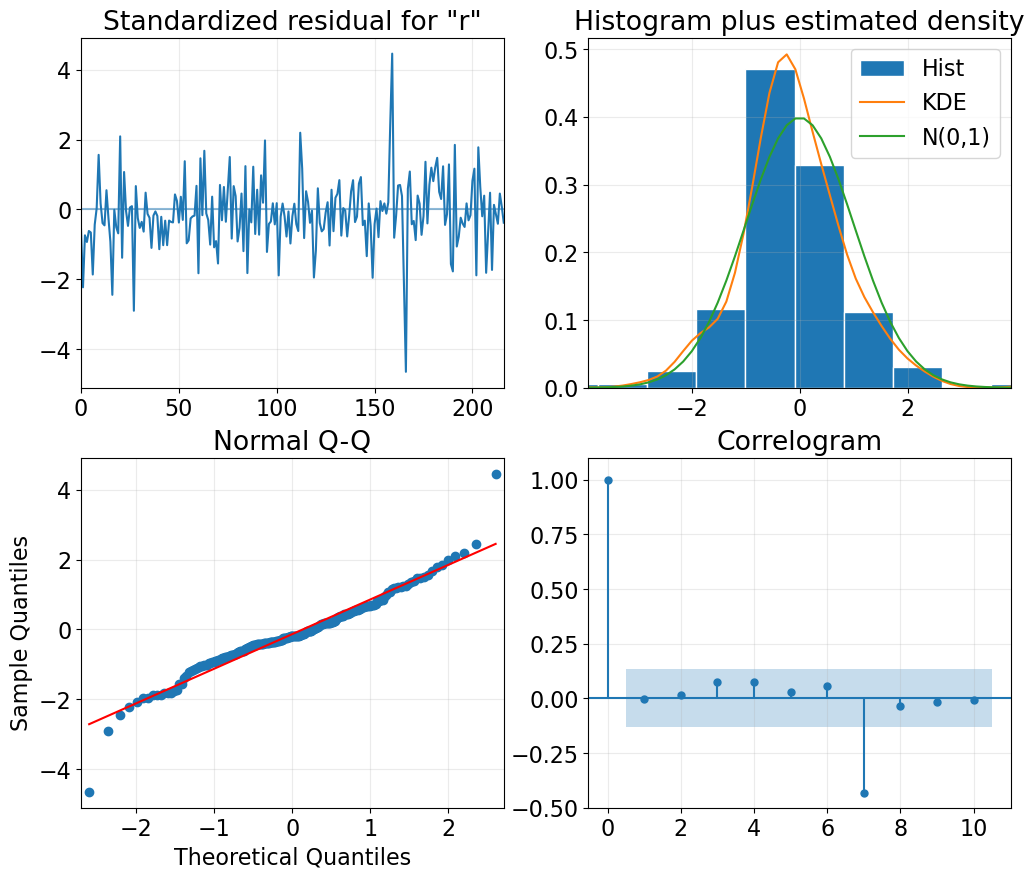

In [106]:
fig = model_sarima_best_fit.plot_diagnostics(figsize=(12, 10))

# get all axes
axs = fig.get_axes()
for ax in axs:
  ax.grid("on")

# set y-lim for correlogram plot
axs[3].set_ylim([-0.5, 1.1])
plt.show(fig)

In [107]:
residuals = model_sarima_best_fit.resid
ljung_box_test = acorr_ljungbox(residuals, np.arange(1, 11))
ljung_box_test

,lb_stat,lb_pvalue
1,1.006387,3.157700e-01
2,2.209189,3.313452e-01
3,5.244798,1.547247e-01
4,7.361089,1.179930e-01
5,8.130452,1.491912e-01
6,8.648341,1.943423e-01
7,50.238772,1.296664e-08
8,51.128586,2.478567e-08
9,51.774048,4.987503e-08
10,52.280862,1.012310e-07


Karena semua nilai p-value lebih besar dari 0.05, kita dapat menyimpulkan bahwa residual dari model yang diuji tidak memiliki autokorelasi yang signifikan, sehingga model sudah cukup baik dalam menangkap pola dalam data.

In [108]:
pred_sarima = model_sarima_best_fit.get_prediction(
  TRAIN_LEN, TRAIN_LEN + HORIZON - 1).predicted_mean

df_test_pred["pred_sarima"] = pred_sarima
df_test_pred

,Tgl. Mohon,count,cumulative_sum,rolling_7days,pred_naive_seasonal,pred_arima,pred_sarima
230,2024-06-07,2,345,12.0,18.0,11.541875,10.947589
231,2024-06-10,2,347,12.0,18.0,11.642842,11.763117
232,2024-06-11,1,348,10.0,17.0,10.241801,13.054344
233,2024-06-12,1,349,10.0,17.0,10.714120,13.284885
234,2024-06-14,2,351,11.0,17.0,11.564678,13.236475
235,2024-06-15,2,353,11.0,17.0,11.238786,12.984436
236,2024-06-18,1,354,11.0,14.0,12.010834,12.885339
237,2024-06-24,1,355,10.0,8.0,12.266092,14.138239
238,2024-06-27,1,356,9.0,7.0,12.059548,13.594808
239,2024-06-28,2,358,10.0,8.0,12.325821,11.625496


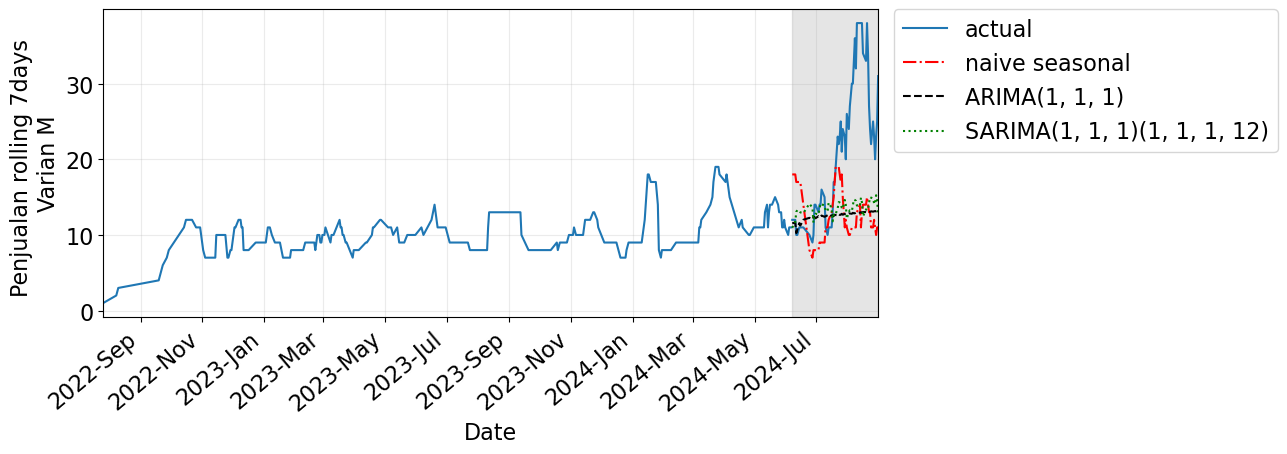

In [109]:
start_idx = 0  # for better visualization
xlim = [df_train["Tgl. Mohon"].iloc[start_idx], df_test["Tgl. Mohon"].iloc[-1]]

fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(df_train["Tgl. Mohon"], df_train["rolling_7days"])
ax.plot(df_test["Tgl. Mohon"], df_test["rolling_7days"], color="tab:blue", label="actual")

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 2))
# locator = mdates.DayLocator()
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)
# ax.set_ylim([-0.5, 17])
ax.set_xlim(xlim)
ax.grid("on")
ax.set_xlabel("Date")
ax.set_ylabel("Penjualan rolling 7days \nVarian M")

# -- prediction
ax.plot(df_test_pred["Tgl. Mohon"], df_test_pred["pred_naive_seasonal"], "r-.", label="naive seasonal")
ax.plot(df_test_pred["Tgl. Mohon"], df_test_pred["pred_arima"], "k--", label="ARIMA(1, 1, 1)")
ax.plot(df_test_pred["Tgl. Mohon"], df_test_pred["pred_sarima"], "g:", label="SARIMA(1, 1, 1)(1, 1, 1, 12)")
(1, 1, 1, 1)

# add forecast area
ax.axvspan(df_test['Tgl. Mohon'].iloc[0], df_test['Tgl. Mohon'].iloc[-1], 
                color="#808080", alpha=0.2)

for j, label in enumerate(ax.get_xticklabels()):
  label.set_rotation(40)
#   label.set_size(8)
  label.set_horizontalalignment('right')

# -- add legend in the second row
ax.legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)

plt.show(fig)

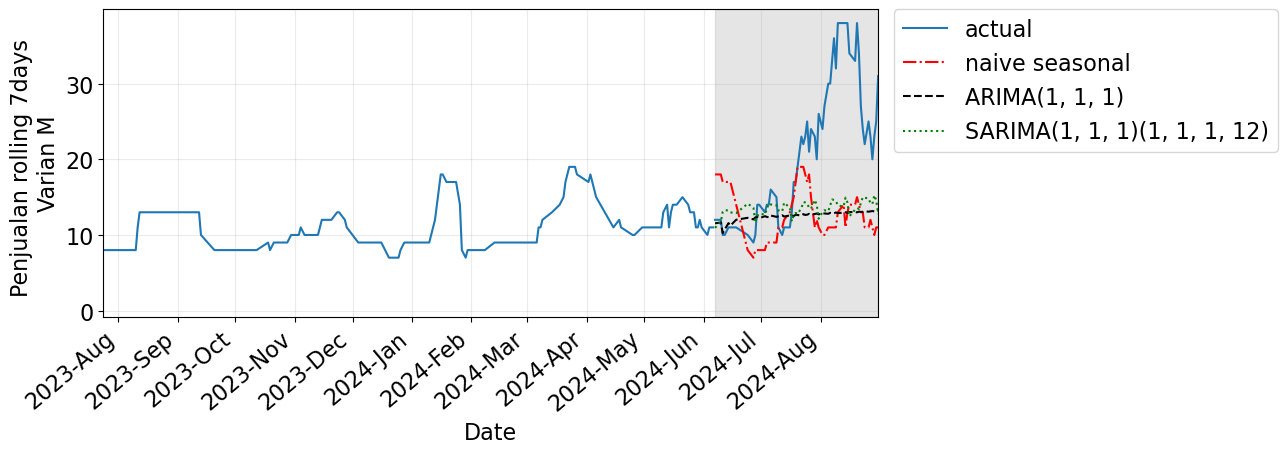

In [110]:
start_idx = 120  # for better visualization
xlim = [df_train["Tgl. Mohon"].iloc[start_idx], df_test["Tgl. Mohon"].iloc[-1]]

fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(df_train["Tgl. Mohon"], df_train["rolling_7days"])
ax.plot(df_test["Tgl. Mohon"], df_test["rolling_7days"], color="tab:blue", label="actual")

# formatter = mdates.DateFormatter("%Y")
formatter = mdates.DateFormatter("%Y-%b")
# locator = mdates.YearLocator(base=2)
locator = mdates.MonthLocator(bymonthday=1, bymonth=range(1, 13, 1))
# locator = mdates.DayLocator()
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_major_locator(locator)
# ax.set_ylim([-0.5, 17])
ax.set_xlim(xlim)
ax.grid("on")
ax.set_xlabel("Date")
ax.set_ylabel("Penjualan rolling 7days \nVarian M")

# -- prediction
ax.plot(df_test_pred["Tgl. Mohon"], df_test_pred["pred_naive_seasonal"], "r-.", label="naive seasonal")
ax.plot(df_test_pred["Tgl. Mohon"], df_test_pred["pred_arima"], "k--", label="ARIMA(1, 1, 1)")
ax.plot(df_test_pred["Tgl. Mohon"], df_test_pred["pred_sarima"], "g:", label="SARIMA(1, 1, 1)(1, 1, 1, 12)")
(1, 1, 1, 1)

# add forecast area
ax.axvspan(df_test['Tgl. Mohon'].iloc[0], df_test['Tgl. Mohon'].iloc[-1], 
                color="#808080", alpha=0.2)

for j, label in enumerate(ax.get_xticklabels()):
  label.set_rotation(40)
#   label.set_size(8)
  label.set_horizontalalignment('right')

# -- add legend in the second row
ax.legend(loc="upper left", bbox_to_anchor=[1.02, 1], borderaxespad=0.)

plt.show(fig)

### Evaluasi

In [111]:
mae_naive_seasonal = mean_absolute_error(df_test_pred["rolling_7days"], df_test_pred["pred_naive_seasonal"])
mae_arima          = mean_absolute_error(df_test_pred["rolling_7days"], df_test_pred["pred_arima"])
mae_sarima         = mean_absolute_error(df_test_pred["rolling_7days"], df_test_pred["pred_sarima"])

print(f"MAE naive seasonal: {mae_naive_seasonal}")
print(f"         MAE ARIMA: {mae_arima}")
print(f"        MAE SARIMA: {mae_sarima}")

MAE naive seasonal: 10.310344827586206
         MAE ARIMA: 9.493213843609874
        MAE SARIMA: 9.086082374623782


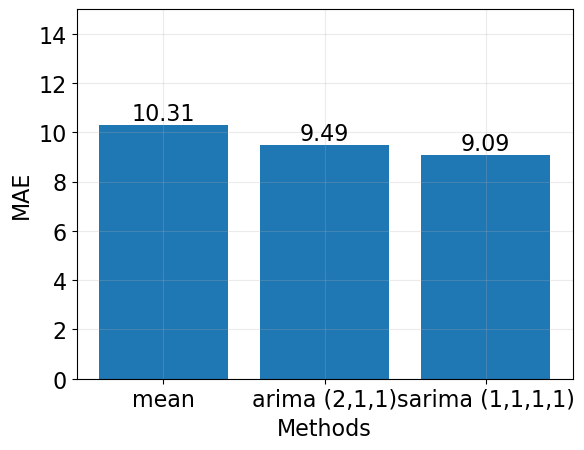

In [112]:
fig, ax = plt.subplots()

x_array = ["mean", "arima (2,1,1)", "sarima (1,1,1,1)"]
y_array = [mae_naive_seasonal, mae_arima, mae_sarima]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MAE")
ax.set_ylim([0, 15])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}", ha="center")

plt.show(fig)

In [113]:
mse_naive_seasonal  = mean_squared_error(df_test_pred["rolling_7days"], df_test_pred["pred_naive_seasonal"])
mse_arima  = mean_squared_error(df_test_pred["rolling_7days"], df_test_pred["pred_arima"])
mse_sarima = mean_squared_error(df_test_pred["rolling_7days"], df_test_pred["pred_sarima"])

print(f"MSE naive seasonal: {mse_naive_seasonal}")
print(f"MSE arima: {mse_arima}")
print(f"MSE sarima: {mse_sarima}")

MSE naive seasonal: 168.0344827586207
MSE arima: 154.97779495847539
MSE sarima: 139.51186722678924


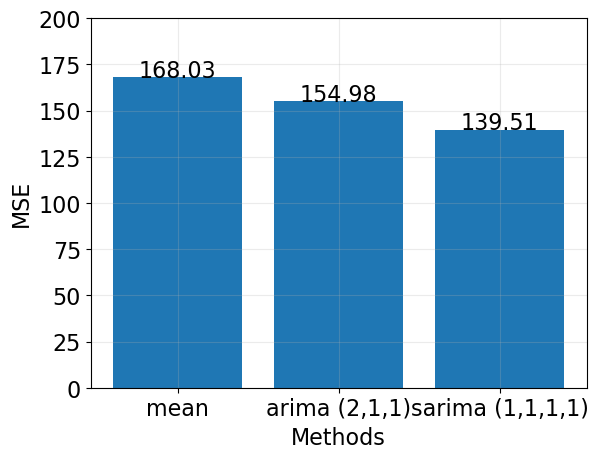

In [114]:
fig, ax = plt.subplots()

x_array = ["mean", "arima (2,1,1)", "sarima (1,1,1,1)"]
y_array = [mse_naive_seasonal, mse_arima, mse_sarima]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MSE")
ax.set_ylim([0, 200])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}", ha="center")

plt.show(fig)

In [115]:
rmse_naive_seasonal = np.sqrt(mse_naive_seasonal)
rmse_arima          = np.sqrt(mse_arima)
rmse_sarima         = np.sqrt(mse_sarima)

print(f"RMSE mean: {rmse_naive_seasonal}")
print(f"RMSE arima: {rmse_arima}")
print(f"RMSE sarima: {rmse_sarima}")

RMSE mean: 12.962811529858046
RMSE arima: 12.449007790120278
RMSE sarima: 11.811514180103634


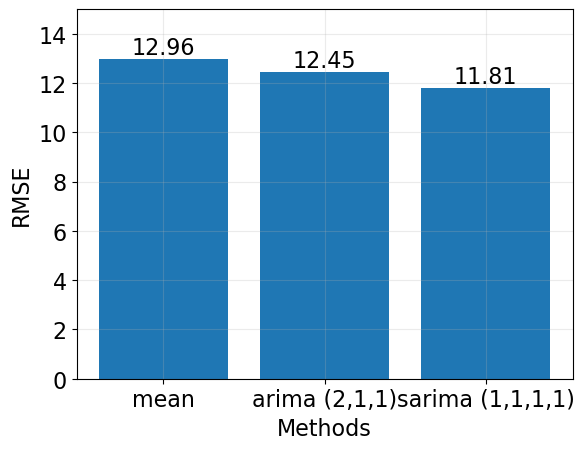

In [116]:
fig, ax = plt.subplots()

x_array = ["mean", "arima (2,1,1)", "sarima (1,1,1,1)"]
y_array = [rmse_naive_seasonal, rmse_arima, rmse_sarima]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("RMSE")
ax.set_ylim([0, 15])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}", ha="center")

plt.show(fig)

In [117]:
mape_naive_seasonal = mean_absolute_percentage_error(df_test_pred["rolling_7days"], df_test_pred["pred_naive_seasonal"]) * 100 
mape_arima          = mean_absolute_percentage_error(df_test_pred["rolling_7days"], df_test_pred["pred_arima"]) * 100
mape_sarima         = mean_absolute_percentage_error(df_test_pred["rolling_7days"], df_test_pred["pred_sarima"]) * 100

print(f"MAPE naive seasonal: {mape_naive_seasonal:5.2f}%")
print(f"         MAPE ARIMA: {mape_arima:5.2f}%")
print(f"        MAPE SARIMA: {mape_sarima:5.2f}%")

MAPE naive seasonal: 42.86%
         MAPE ARIMA: 35.85%
        MAPE SARIMA: 35.69%


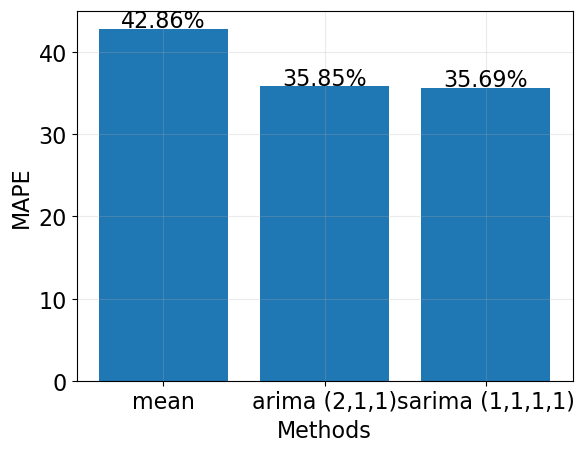

In [118]:
fig, ax = plt.subplots()

x_array = ["mean", "arima (2,1,1)", "sarima (1,1,1,1)"]
y_array = [mape_naive_seasonal, mape_arima, mape_sarima]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MAPE")
ax.set_ylim([0, 45])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}%", ha="center")

plt.show(fig)

In [119]:
naive = np.abs(np.diff(df_train["rolling_7days"])).mean()

mase_naive_seasonal = mae_naive_seasonal / naive
mase_arima = mae_arima / naive
mase_sarima  = mae_sarima / naive

print(f"MASE naive seasonal: {mase_naive_seasonal}")
print(f"MASE arima: {mase_arima}")
print(f"MASE sarima: {mase_sarima}")

MASE naive seasonal: 13.888640973630832
MASE arima: 12.787917471686244
MASE sarima: 12.239487434052036


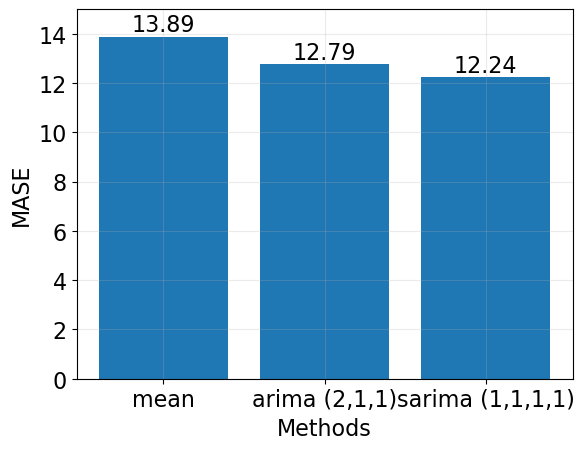

In [120]:
fig, ax = plt.subplots()

x_array = ["mean", "arima (2,1,1)", "sarima (1,1,1,1)"]
y_array = [mase_naive_seasonal, mase_arima, mase_sarima]

ax.bar(x_array, y_array)
ax.grid("on")
ax.set_xlabel("Methods")
ax.set_ylabel("MASE")
ax.set_ylim([0, 15])

for idx, val in enumerate(y_array):
  ax.text(x=idx, y=val+.2, s=f"{val:.2f}", ha="center")

plt.show(fig)